# Importing Dependencies

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import os
from collections import Counter

In [19]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Preprocessing

In [20]:
# === Settings ===
image_size = (128, 128)
batch_size = 32

In [21]:
def get_image_filepaths_and_class_labels(data_dir):
    class_names = sorted([
        d for d in os.listdir(data_dir)
        if os.path.isdir(os.path.join(data_dir, d))
    ])

    filepaths = []
    class_indices = []

    for class_index, class_name in enumerate(class_names):
        class_folder = os.path.join(data_dir, class_name)
        image_files = [
            f for f in os.listdir(class_folder)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ]
        for filename in image_files:
            filepaths.append(os.path.join(class_folder, filename))
            class_indices.append(class_index)

    # ✅ Shuffle to avoid class bias
    combined = list(zip(filepaths, class_indices))
    np.random.shuffle(combined)
    filepaths, class_indices = zip(*combined)

    return list(filepaths), list(class_indices), class_names

In [22]:
def preprocess_image_cv(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, image_size)
    image = image.astype(np.float32) / 255.0
    return image


In [23]:
def to_one_hot(index, total_classes):
    encoded = np.zeros(total_classes, dtype=np.float32)
    encoded[index] = 1.0
    return encoded

In [24]:
def load_image_dataset_cv(data_dir):
    filepaths, class_indices, class_names = get_image_filepaths_and_class_labels(data_dir)
    total_classes = len(class_names)
    print(f"Found {len(filepaths)} images across {total_classes} classes.")
    print("Sample class counts:", dict(Counter(class_indices)))

    image_data = []
    encoded_labels = []
    for path, label in zip(filepaths, class_indices):
        image = preprocess_image_cv(path)
        one_hot_label = to_one_hot(label, total_classes)
        image_data.append(image)
        encoded_labels.append(one_hot_label)
    return image_data, encoded_labels, class_names

In [25]:
def batch_images_and_labels(image_data, encoded_labels, batch_size):
    all_batches = []
    for start in range(0, len(image_data), batch_size):
        batch_images = np.array(image_data[start:start+batch_size])
        batch_labels = np.array(encoded_labels[start:start+batch_size])
        all_batches.append((batch_images, batch_labels))
    return all_batches

# Load dataset and create batches
image_data, encoded_labels, class_names = load_image_dataset_cv("New Plant Diseases Dataset(Augmented)/train")
batches = batch_images_and_labels(image_data, encoded_labels, batch_size)

# Display information about the first batch
first_batch_imgs, first_batch_lbls = batches[0]
print("First batch shapes:", first_batch_imgs.shape, first_batch_lbls.shape)

In [ ]:
# Load train data
train_images, train_labels, class_names = load_image_dataset_cv("New Plant Diseases Dataset(Augmented)/train")

# Create train batches
train_batches = batch_images_and_labels(train_images, train_labels, batch_size)

# Inspect
print("Train batch shape:", train_batches[0][0].shape, train_batches[0][1].shape)

Found 70295 images across 38 classes.
Sample class counts: {6: 1826, 36: 1790, 27: 1824, 11: 1888, 20: 1939, 8: 1907, 26: 1774, 9: 1908, 2: 1760, 18: 1913, 21: 1939, 29: 1920, 16: 1838, 10: 1859, 37: 1926, 24: 2022, 15: 2010, 17: 1728, 12: 1920, 25: 1736, 14: 1692, 4: 1816, 0: 2016, 7: 1642, 30: 1851, 34: 1827, 5: 1683, 22: 1824, 1: 1987, 19: 1988, 35: 1961, 3: 2008, 31: 1882, 23: 1781, 28: 1702, 32: 1745, 13: 1722, 33: 1741}


In [10]:
def batch_generator(train_batches):
    for batch_images, batch_labels in train_batches:
        yield batch_images, batch_labels

def convert_batches_to_tf_dataset(train_batches):
    num_batches = len(train_batches)  # Count total batches
    
    dataset = tf.data.Dataset.from_generator(
        lambda: batch_generator(train_batches),
        output_signature=(
            tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, len(train_batches[0][1][0])), dtype=tf.float32)
        )
    )
    
    # Add .take() to enforce a fixed number of elements
    dataset = dataset.take(num_batches)
    dataset = dataset.shuffle(buffer_size=100)
    
    # Prefetch for performance
    return dataset.prefetch(tf.data.AUTOTUNE)


In [11]:
train_ds = convert_batches_to_tf_dataset(train_batches)

In [12]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 38), dtype=tf.float32, name=None))>

In [17]:
for images, labels in train_ds.take(1):
    for i in range(9):
        print(f"Label {i}: {labels[i].numpy()}")


Label 0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label 2: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label 3: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label 4: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Label 5: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label 6: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label 7: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [18]:
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

Label 0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label 2: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label 3: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label 4: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Label 5: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label 6: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label 7: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

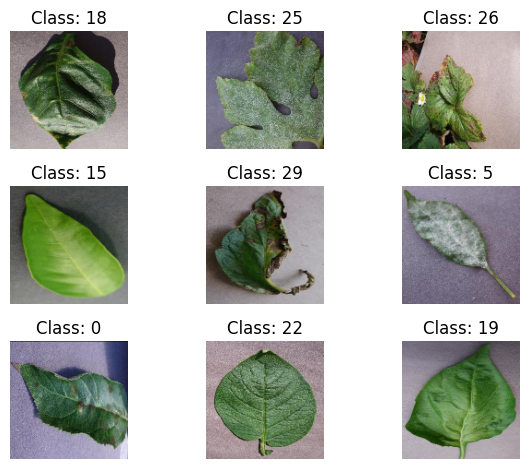

In [19]:
for images, labels in train_ds.take(1):
    for i in range(9):
        print(f"Label {i}: {labels[i].numpy()}")
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy())
        plt.title(f"Class: {np.argmax(labels[i].numpy())}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

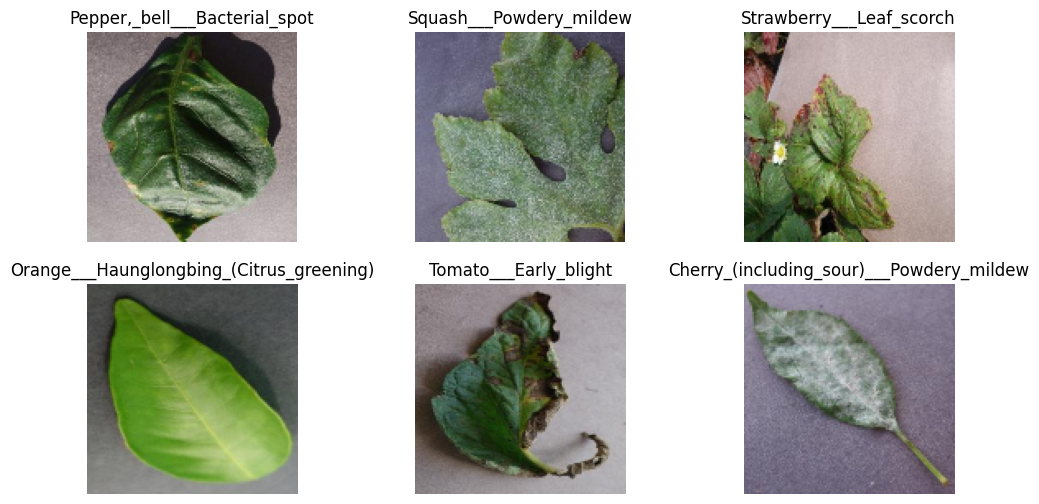

In [37]:
plt.figure(figsize=(12, 6))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy())
        class_index = np.argmax(labels[i].numpy())  # Get class index from one-hot
        plt.title(class_names[class_index])
        plt.axis("off")

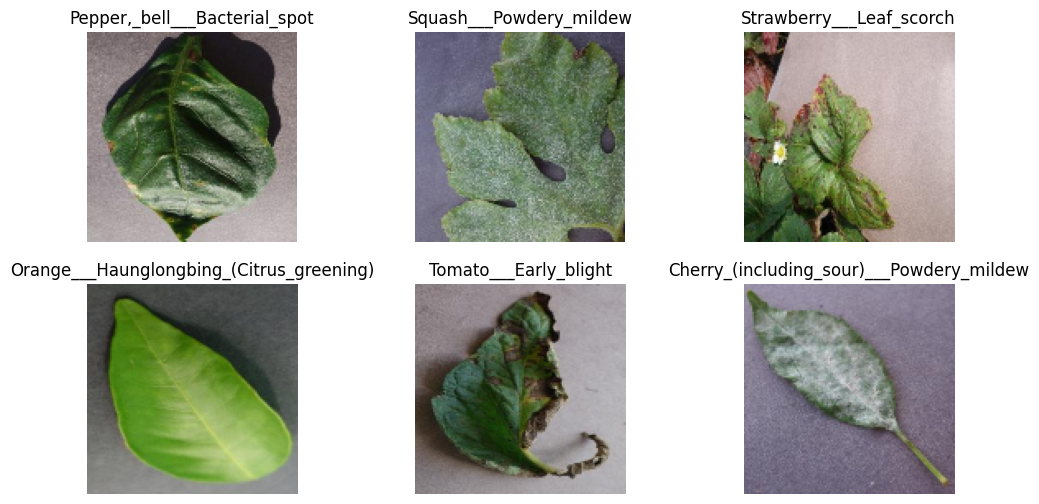

In [24]:
plt.figure(figsize=(12, 6))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy())
        class_index = np.argmax(labels[i].numpy())  # Get class index from one-hot
        plt.title(class_names[class_index])
        plt.axis("off")

In [1]:
shown_classes = set()

plt.figure(figsize=(16, 10))

count = 0
for img, label in zip(train_images, train_labels):
    class_index = np.argmax(label)
    if class_index not in shown_classes:
        shown_classes.add(class_index)
        plt.subplot(6, 7, count + 1)  # adjust grid if needed
        plt.imshow(img)
        plt.title(class_names[class_index], fontsize=8)
        plt.axis("off")
        count += 1
    if len(shown_classes) == len(class_names):
        break

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

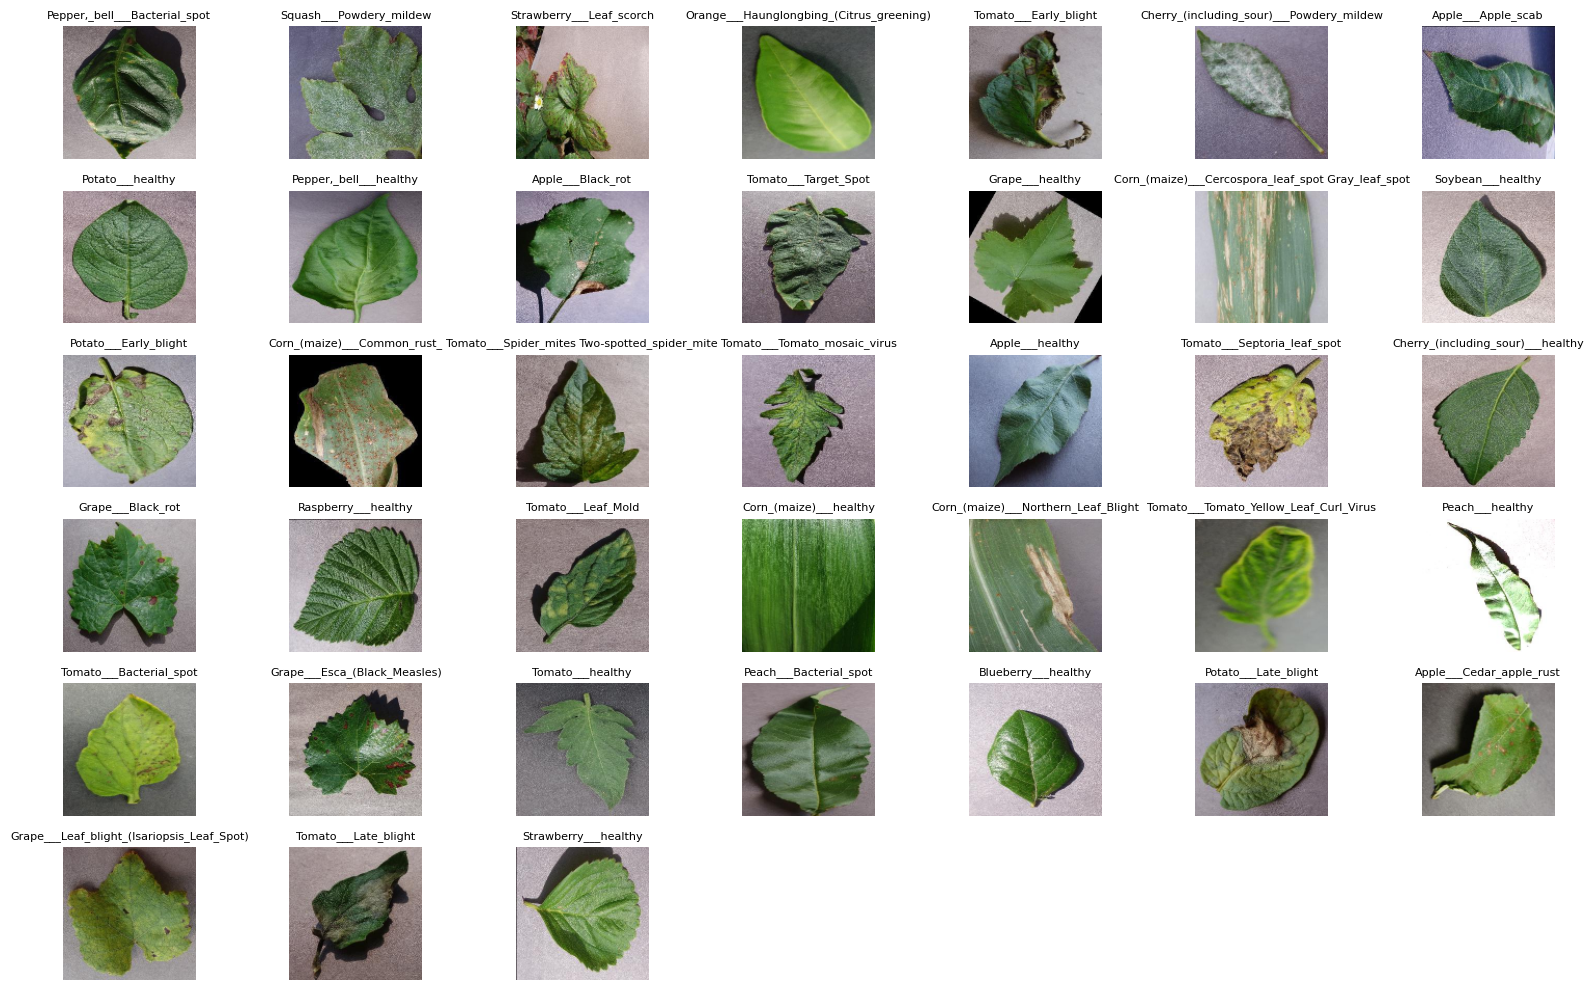

In [34]:
shown_classes = set()

plt.figure(figsize=(16, 10))

count = 0
for img, label in zip(train_images, train_labels):
    class_index = np.argmax(label)
    if class_index not in shown_classes:
        shown_classes.add(class_index)
        plt.subplot(6, 7, count + 1)  # adjust grid if needed
        plt.imshow(img)
        plt.title(class_names[class_index], fontsize=8)
        plt.axis("off")
        count += 1
    if len(shown_classes) == len(class_names):
        break

plt.tight_layout()
plt.show()

In [36]:
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [38]:
print("Manual train_ds element_spec:", train_ds.element_spec)

Manual train_ds element_spec: (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 38), dtype=tf.float32, name=None))


In [41]:
print("Manual class names:", class_names)

Manual class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',